In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from netCDF4 import Dataset
import os,glob
import pandas as pd
import datetime as dt
from h5py import File

%matplotlib ipympl

In [63]:
def update_bp(temp_dark_std=None,temp_dark_mean=None):
    new_bad_pixel_mask = np.zeros(temp_dark_mean.shape)
    new_bad_pixel_mask[temp_dark_std < 1] = 2  # Dead Pixels
    new_bad_pixel_mask[
        np.logical_and(temp_dark_mean < 1000, temp_dark_std < 1)
    ] = 2**6  # COLD Pixels
    new_bad_pixel_mask[
        np.logical_and(temp_dark_mean > 3000, temp_dark_std < 1)
    ] = 2**7  # HOT Pixels
    new_bad_pixel_mask[temp_dark_std > 5 * np.nanmean(temp_dark_std)] = 2**5
    return new_bad_pixel_mask

In [2]:
ch4_files = np.array(sorted(list(Path('./').rglob('*CH4*.nc'))))
o2_files = np.array(sorted(list(Path('./').rglob('*O2*.nc'))))

In [18]:
bad_darks = ['04B00001', '03D10001', '080F0001', '06400001', '05370001', '063F0001', '05850001', '03BA0001', '00F20001', '07FA0001', '05490001']
inds = []
for s in bad_darks:
    tind = np.where([str(d).split('/')[3] == s for d in ch4_files])
    inds.append(tind[0])
inds

[array([232]),
 array([176]),
 array([385, 386]),
 array([309]),
 array([263]),
 array([308]),
 array([276]),
 array([166]),
 array([47]),
 array([375]),
 array([267])]

In [56]:
ch4_files[inds[0][0]]

PosixPath('2024/12/15/04B00001/202412162103_po-2260/MethaneSAT_L0_CH4_Dark_0_04B00001.nc')

In [66]:
ch4_bp = Dataset('../level1a_calibration_MSAT_20250722.0.0_CH4_BadPixelMap_CH4_20250722.nc','r')['BadPixelMap'][:] 
o2_bp = Dataset('../level1a_calibration_MSAT_20250722.0.0_O2_BadPixelMap_O2_20250722.nc','r')['BadPixelMap'][:] 

fid_ch4 = Dataset(ch4_files[inds[0][0]],'r')
dkch4 = fid_ch4['Frame/PixelData'][:]
dkch4_std = np.nanstd(fid_ch4['Frame/PixelData'][:],0)
t = fid_ch4['Frame/TimeStamp'][:].data.astype(int)//1e6
for i in range(20):
    dkch4.mask[i] = np.logical_or(dkch4.mask[i],(ch4_bp > 0))
dkch4_std.mask = np.logical_or(dkch4_std.mask,(ch4_bp > 0))

dkch4_std_mask = np.logical_or(ch4_bp,update_bp(temp_dark_std=dkch4_std,temp_dark_mean=np.nanmean(dkch4,0)))


fid_o2 = Dataset(o2_files[inds[0][0]],'r')
dko2 = fid_o2['Frame/PixelData'][:]
dko2_std = np.nanstd(fid_o2['Frame/PixelData'][:],0)
t = fid_o2['Frame/TimeStamp'][:].data.astype(int)//1e6
for i in range(20):
    dko2.mask[i] = np.logical_or(dko2.mask[i],(o2_bp > 0))
dko2_std.mask = np.logical_or(dko2_std.mask,(o2_bp > 0))
dko2_std_mask = np.logical_or(o2_bp,update_bp(temp_dark_std=dko2_std,temp_dark_mean=np.nanmean(dko2,0)))


In [77]:
Dataset('../level1a_calibration_MSAT_20250722.0.0_CH4_BadPixelMap_CH4_20250722.nc','r')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): across_track(2048), spectral_channel(2048)
    variables(dimensions): uint16 BadPixelMap(across_track, spectral_channel)
    groups: 

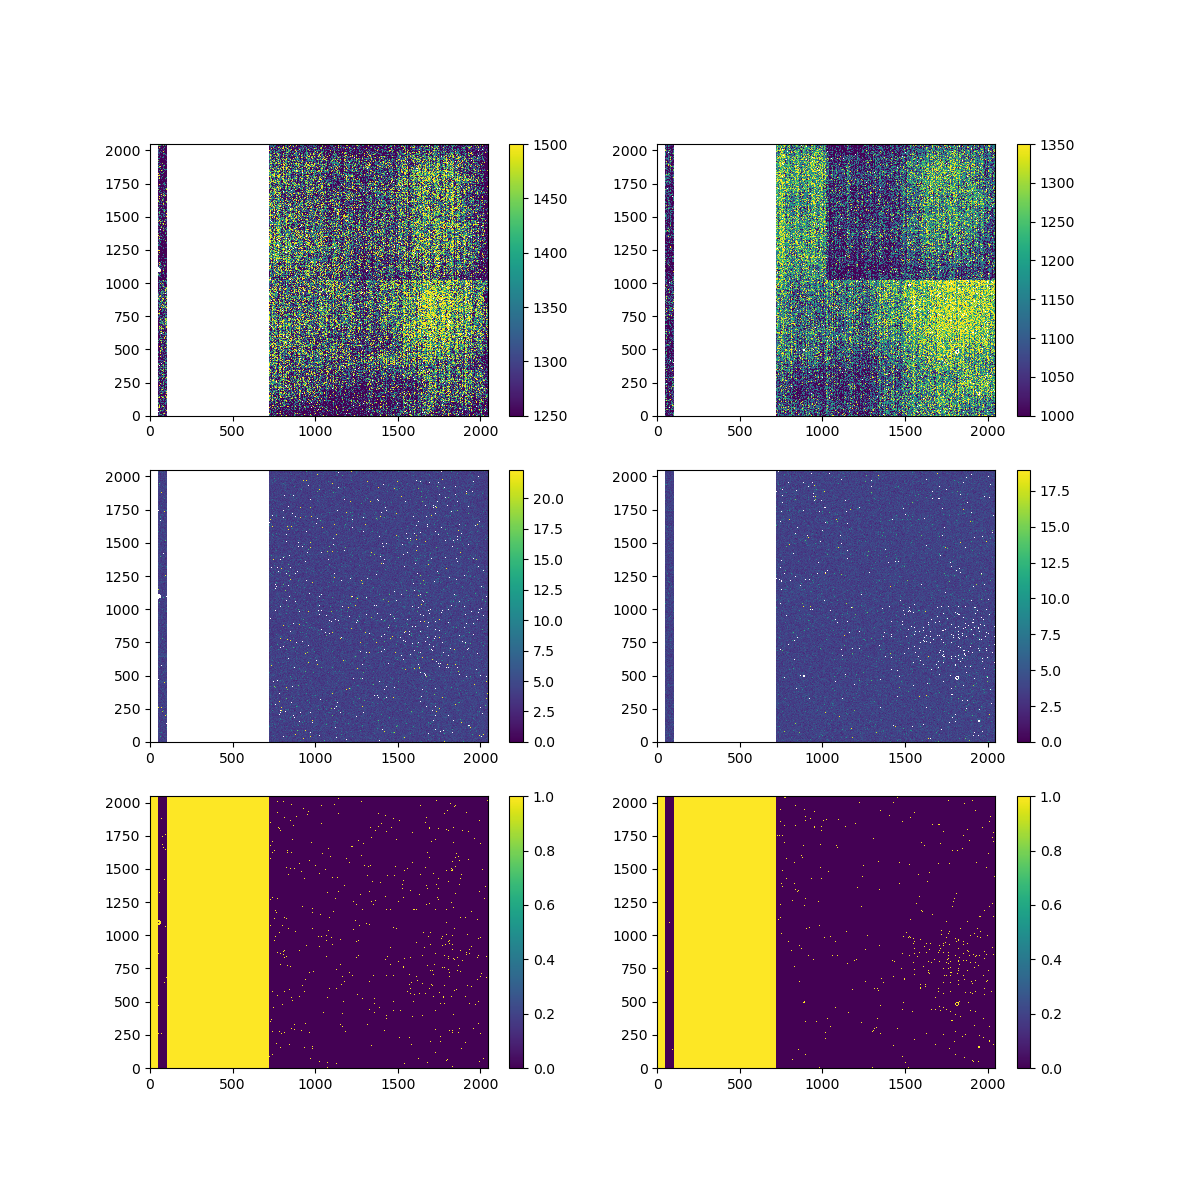

In [68]:
fig,axs = plt.subplots(3,2,figsize=(12,12))
ax = axs[0,0]
g = ax.pcolormesh(dkch4[0],vmin=1250,vmax=1500); plt.colorbar(g,ax=ax)

ax = axs[0,1]
g = ax.pcolormesh(dko2[0],vmin=1000,vmax=1350); plt.colorbar(g,ax=ax)

ax = axs[1,0]
g = ax.pcolormesh(dkch4_std,vmin=0,vmax=5*dkch4_std.mean()); plt.colorbar(g,ax=ax)

ax = axs[1,1]
g = ax.pcolormesh(dko2_std,vmin=0,vmax=5*dko2_std.mean()); plt.colorbar(g,ax=ax)

ax = axs[2,0]
g = ax.pcolormesh(dkch4_std_mask,vmin=0,vmax=1); plt.colorbar(g,ax=ax)

ax = axs[2,1]
g = ax.pcolormesh(dko2_std_mask-o2_bp,vmin=0,vmax=1); plt.colorbar(g,ax=ax)

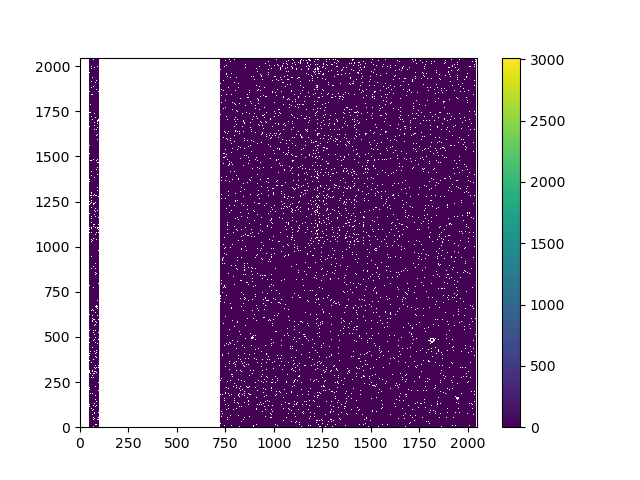

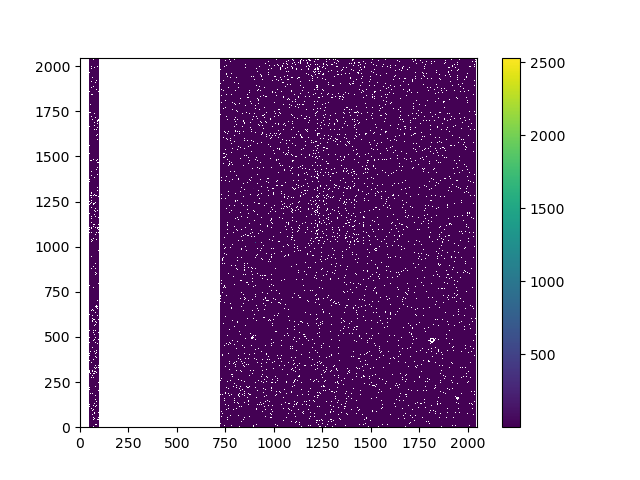

In [32]:
plt.figure(); plt.pcolormesh(dkch4_std); plt.colorbar()
plt.figure(); plt.pcolormesh(dko2_std); plt.colorbar()

/tmp/ipykernel_636665/2605803068.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(); plt.pcolormesh(dkch4_mask.sum(0)); plt.colorbar()


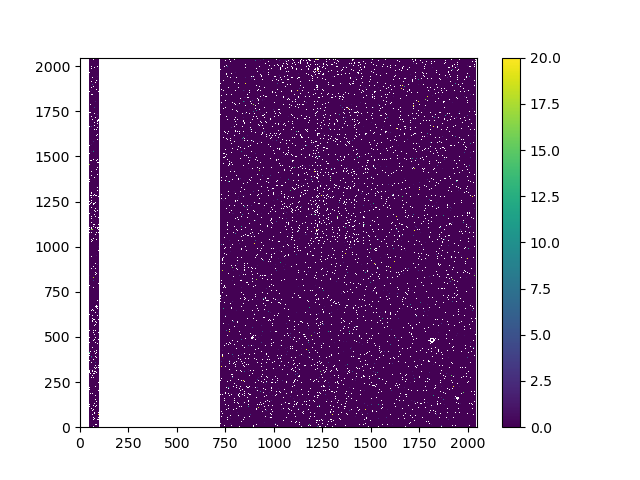

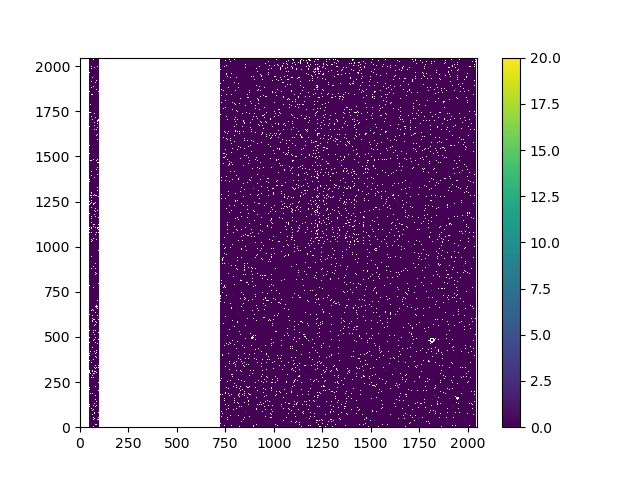

In [44]:
plt.figure(); plt.pcolormesh(dkch4_mask.sum(0)); plt.colorbar()
plt.figure(); plt.pcolormesh(dko2_mask.sum(0)); plt.colorbar()

In [3]:
ch4_file_dates = [dt.datetime(int(str(s).split('/')[0]),int(str(s).split('/')[1]),int(str(s).split('/')[2])) for s in ch4_files]
ch4_file_dates

[datetime.datetime(2024, 6, 14, 0, 0),
 datetime.datetime(2024, 6, 15, 0, 0),
 datetime.datetime(2024, 6, 21, 0, 0),
 datetime.datetime(2024, 6, 21, 0, 0),
 datetime.datetime(2024, 6, 21, 0, 0),
 datetime.datetime(2024, 6, 22, 0, 0),
 datetime.datetime(2024, 6, 22, 0, 0),
 datetime.datetime(2024, 7, 19, 0, 0),
 datetime.datetime(2024, 7, 19, 0, 0),
 datetime.datetime(2024, 7, 19, 0, 0),
 datetime.datetime(2024, 7, 19, 0, 0),
 datetime.datetime(2024, 7, 19, 0, 0),
 datetime.datetime(2024, 7, 19, 0, 0),
 datetime.datetime(2024, 7, 19, 0, 0),
 datetime.datetime(2024, 7, 19, 0, 0),
 datetime.datetime(2024, 7, 19, 0, 0),
 datetime.datetime(2024, 7, 19, 0, 0),
 datetime.datetime(2024, 7, 19, 0, 0),
 datetime.datetime(2024, 7, 19, 0, 0),
 datetime.datetime(2024, 7, 21, 0, 0),
 datetime.datetime(2024, 7, 21, 0, 0),
 datetime.datetime(2024, 7, 21, 0, 0),
 datetime.datetime(2024, 7, 21, 0, 0),
 datetime.datetime(2024, 7, 21, 0, 0),
 datetime.datetime(2024, 7, 21, 0, 0),
 datetime.datetime(2024, 

In [ ]:
ch4_dk = 

In [4]:
ch4_ts = np.array([Dataset(fn)['Frame/TimeStamp'][:].max().astype(int)//1e6 for fn in ch4_files])
o2_ts = np.array([Dataset(fn)['Frame/TimeStamp'][:].max().astype(int)//1e6 for fn in o2_files])


In [5]:
ch4_dk_dt = np.array([ dt.datetime(1980,1,1) + dt.timedelta(seconds=t) for t in ch4_ts])
o2_dk_dt = np.array([ dt.datetime(1980,1,1) + dt.timedelta(seconds=t) for t in o2_ts])


In [9]:
mean_ch4_dark = np.nanmean(Dataset('ch4_darks.h5','r')['dark'][:],axis=(1,2))
mean_o2_dark = np.nanmean(Dataset('o2_darks.h5','r')['dark'][:],axis=(1,2))

In [12]:
ch4_dk_dt.shape

(580,)

In [10]:
ch4_df = pd.DataFrame({'mean_ch4_dark':mean_ch4_dark},index=ch4_dk_dt)                                                 
o2_df = pd.DataFrame({'mean_o2_dark':mean_o2_dark},index=o2_dk_dt)
ch4_df['mean'] = ch4_df.mean()['mean_ch4_dark']*np.ones(len(ch4_df.index))
o2_df['mean'] = o2_df.mean()['mean_o2_dark']*np.ones(len(o2_df.index))

del ch4_dk_dt
del o2_dk_dt
del mean_ch4_dark
del mean_o2_dark

ValueError: Length of values (581) does not match length of index (580)

In [ ]:
ch4_df = ch4_df[ch4_df.index > dt.datetime(2024,8,1)]
o2_df = o2_df[o2_df.index > dt.datetime(2024,8,1)]


In [ ]:
ch4_df.plot(marker='.',linestyle='none')
plt.gca().set_ylim([1324,1334])
o2_df.plot(marker='.',linestyle='none')
plt.gca().set_ylim([1140,1150])

In [ ]:
telem_files = sorted(glob.glob('../telemetry/*.csv'))[15:]
telem_dates = np.array([[int(d) for d in tf.split('/')[-1].split('_science')[0].split('_')[:]] for tf in telem_files])

telem_df = pd.read_csv(telem_files[0])

telem_df.index = np.array([dt.datetime.strptime(dd,"%Y-%m-%dT%H:%M:%S.%fZ") for dd in telem_df['Time'][:]])
del telem_df['Time']
telem_df['date'] = telem_df.index
for ky in telem_df.columns:
    if telem_df[ky].dtype == np.dtype('O'):
        del telem_df[ky]
telem_df = telem_df.resample('1min').mean()

for fi in telem_files[1:]:
    df = pd.read_csv(fi)
    if df.empty: continue
    if 'Time' in df.columns:
        t = df['Time']
    elif 'ft' in df.columns:
        t = df['ft']
    else:
        print(f'{fi} has undefined Time variable, skipping...')
        continue
    df.index = np.array([dt.datetime.strptime(dd,"%Y-%m-%dT%H:%M:%S.%fZ") for dd in t[:]])
    df['date'] = df.index
    del t
    for ky in df.columns:
        if df[ky].dtype == np.dtype('O'):
            del df[ky]
            continue
        if ky == 'Time': 
            del df[ky]
            continue
        if ky == 'ft': 
            del df[ky]
            continue
    if df.empty: continue
    df = df.resample('1min').mean()
    telem_df = pd.concat([telem_df,df])

In [11]:
telem_df['T_OP_BENCH_TEMP'][dt.datetime(2024,8,1):dt.datetime(2024,8,20)].plot(marker='.',linestyle='none',color='r',markersize=1)

NameError: name 'telem_df' is not defined

In [ ]:
start_date = dt.datetime(2024,8,1)
end_date=dt.datetime(2024,9,1)
telem_df = telem_df.sort_index()
fig,ax = plt.subplots(1)
telem_df['T_OP_BENCH_TEMP'][start_date:end_date].plot(marker='.',linestyle='none',ax=ax,color='r')
#telem_df['T_OP_BENCH_TEMP'][start_date:end_date].rolling('1D').mean().plot()
ax2 = ax.twinx()
ch4_df[start_date:end_date]['mean_ch4_dark'].plot(marker='.',linestyle='none',ax=ax2)
ax2.set_ylim([1324,1334])

In [ ]:
times = np.array([ dd for dd in pd.to_datetime(ch4_df.index) ])
inds = np.array([telem_df.index.searchsorted(tt) for tt in times])
ch4_df_t = pd.concat([telem_df.iloc[inds],ch4_df])
o2_df_t = pd.concat([telem_df.iloc[inds],o2_df])

In [ ]:
fig,ax = plt.subplots(1)
good_inds = np.where(1-pd.isna(ch4_df_t['mean_ch4_dark']))
ch4_df_t.iloc[good_inds]['mean_ch4_dark'].plot(marker='.',linestyle='none',ax=ax)
ax.set_ylim([1330,1335])

In [ ]:
fig,ax = plt.subplots(1)
telem_df['T_OP_BENCH_TEMP'].plot(marker='.',linestyle='none',ax=ax,color='r')
ax.set_ylim([19,21])
ax2 = ax.twinx()
ch4_df_t['mean_ch4_dark'].plot(marker='.',linestyle='none',ax=ax2)
ax2.set_ylim([1324,1334])

fig,ax = plt.subplots(1)
telem_df['T_OP_BENCH_TEMP'].plot(marker='.',linestyle='none',ax=ax,color='r')
ax.set_ylim([19,21])
ax2 = ax.twinx()
o2_df_t['mean_o2_dark'].plot(marker='.',linestyle='none',ax=ax2)
ax2.set_ylim([1140,1150])

In [ ]:
ch4_df_t['mean_ch4_dark'].shape

In [ ]:
help(pd.DataFrame.rolling)

In [7]:
ch4_files[-10:]

array([PosixPath('2025/06/12/0D6D0001/202506151739_po-2575/MethaneSAT_L0_CH4_Dark_0_0D6D0001.nc'),
       PosixPath('2025/06/12/0D6E0001/202506151739_po-2575/MethaneSAT_L0_CH4_Dark_0_0D6E0001.nc'),
       PosixPath('2025/06/13/0D840001/202506161758_po-2577/MethaneSAT_L0_CH4_Dark_0_0D840001.nc'),
       PosixPath('2025/06/13/0D850001/202506161758_po-2577/MethaneSAT_L0_CH4_Dark_0_0D850001.nc'),
       PosixPath('2025/06/13/0D860001/202506161758_po-2577/MethaneSAT_L0_CH4_Dark_0_0D860001.nc'),
       PosixPath('2025/06/13/0D870001/202506161758_po-2577/MethaneSAT_L0_CH4_Dark_0_0D870001.nc'),
       PosixPath('2025/06/14/0D9C0001/202506171803_po-2579/MethaneSAT_L0_CH4_Dark_0_0D9C0001.nc'),
       PosixPath('2025/06/14/0D9D0001/202506171803_po-2579/MethaneSAT_L0_CH4_Dark_0_0D9D0001.nc'),
       PosixPath('2025/06/14/0D9E0001/202506171803_po-2579/MethaneSAT_L0_CH4_Dark_0_0D9E0001.nc'),
       PosixPath('2025/06/14/0D9F0001/202506171803_po-2579/MethaneSAT_L0_CH4_Dark_0_0D9F0001.nc')],
      dty

In [8]:
telem_files[-10:]

NameError: name 'telem_files' is not defined